# Laboratorio 1

Importamos librerias

In [38]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import numpy as np
from selenium.webdriver.chrome.webdriver import WebDriver
import warnings
%matplotlib inline
quandl.ApiConfig.api_key = 'riVhxyiwNtvu-2DbzJsD'

In [2]:
def get_etf_holdings(etf_symbol):
    '''
    etf_symbol: str
    
    return: pd.DataFrame
    '''
    url = 'https://www.barchart.com/stocks/quotes/{}/constituents?page=all'.format(
        etf_symbol)

    # Loads the ETF constituents page and reads the holdings table
    browser = WebDriver() # webdriver.PhantomJS()
    browser.get(url)
    html = browser.page_source
    soup = BeautifulSoup(html, 'html')
    table = get_table(soup)

    # Reads the holdings table line by line and appends each asset to a
    # dictionary along with the holdings percentage
    asset_dict = {}
    for row in table.select('tr')[1:-1]:
        try:
            cells = row.select('td')
            # print(row)
            symbol = cells[0].get_text().strip()
            # print(symbol)
            name = cells[1].text.strip()
            celltext = cells[2].get_text().strip()
            percent = float(celltext.rstrip('%'))
            shares = int(cells[3].text.strip().replace(',', ''))
            if symbol != "" and percent != 0.0:
                asset_dict[symbol] = {
                    'name': name,
                    'percent': percent,
                    'shares': shares,
                }
        except BaseException as ex:
            print(ex)
    browser.quit()
    return pd.DataFrame(asset_dict)

Descargamos el nombre de los tickers para poder conseguir los precios de cada activo facilmente

In [49]:
tw = pd.read_csv("DVY_holdings.csv",skiprows=10,usecols=[0,3,5]).dropna()

In [55]:
data = quandl.get_table('WIKI/PRICES', ticker = [tw.iloc[:,0].values], 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2017-03-01', 'lte': '2018-03-01' }, 
                        paginate=True)

Separamos por grupos

In [59]:
grupos = data.groupby("ticker")

In [60]:
etf = [grupos.get_group(x) for x in grupos.groups]

In [82]:
[i for i in tw.iloc[:,0] for j in DVY.columns if i != j]

SyntaxError: invalid syntax (<ipython-input-82-c51a32f9c542>, line 1)

In [83]:
l = []
for i in tw.iloc[:,0]:
    for j in DVY.columns:
        if i != j:
            l.append(i)
            break
            

Acomodamos para que quede la fecha como indice y los precios de los activos en cada columna

In [62]:
etf = [etf[i].set_index("date").rename(columns = {'adj_close':etf[i].iloc[0][0]}).drop(columns = ("ticker"))
      for i in range(len(etf))]

In [63]:
DVY = etf[0]
for i in range(1,len(etf)):
    DVY = DVY.join(etf[i])

In [65]:
DVYret = DVY.apply(lambda x: np.log(x/x.shift(-1)).dropna())

In [68]:
w = [np.random.random(len(DVY.columns)) for i in range(1000)]
sw = [sum(i) for i in w]
w = list(map(lambda x,y: x/y,w,sw))
media = DVYret.mean()
varianza = DVYret.var()
desvest = DVYret.std()
cov = DVYret.cov()

In [67]:
peso = tw.iloc[:,1]

In [69]:
wret = sum(media*peso),np.sqrt(np.dot(np.transpose(peso), np.dot(cov, peso))),peso
etf1 = pd.DataFrame(wret,columns = ["E[Rp]","Sigma","W"])

ValueError: shapes (99,99) and (104,) not aligned: 99 (dim 1) != 104 (dim 0)

In [258]:
wret = [[sum(media*i),np.sqrt(np.dot(np.transpose(i), np.dot(cov, i))),i] for i in w]
port = pd.DataFrame(wret,columns = ["E[Rp]","Sigma","W"])

Text(0,0.5,'E[Rp]')

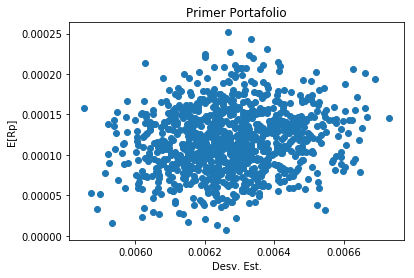

In [266]:
plt.plot(port.iloc[:,1],port.iloc[:,0],"o")
plt.title("Primer Portafolio")
plt.xlabel("Desv. Est.")
plt.ylabel("E[Rp]")

In [269]:
port["Sharpe"] = list(map(lambda x,y: x/y,port.iloc[:,0],port.iloc[:,1]))

In [273]:
min_volatility = port['Sigma'].min()
max_sharpe = port['Sharpe'].max()

sharpe_portfolio = port.loc[port['Sharpe'] == max_sharpe]
min_variance_port = port.loc[port['Sigma'] == min_volatility]

Text(0.5,1,'Efficient Frontier')

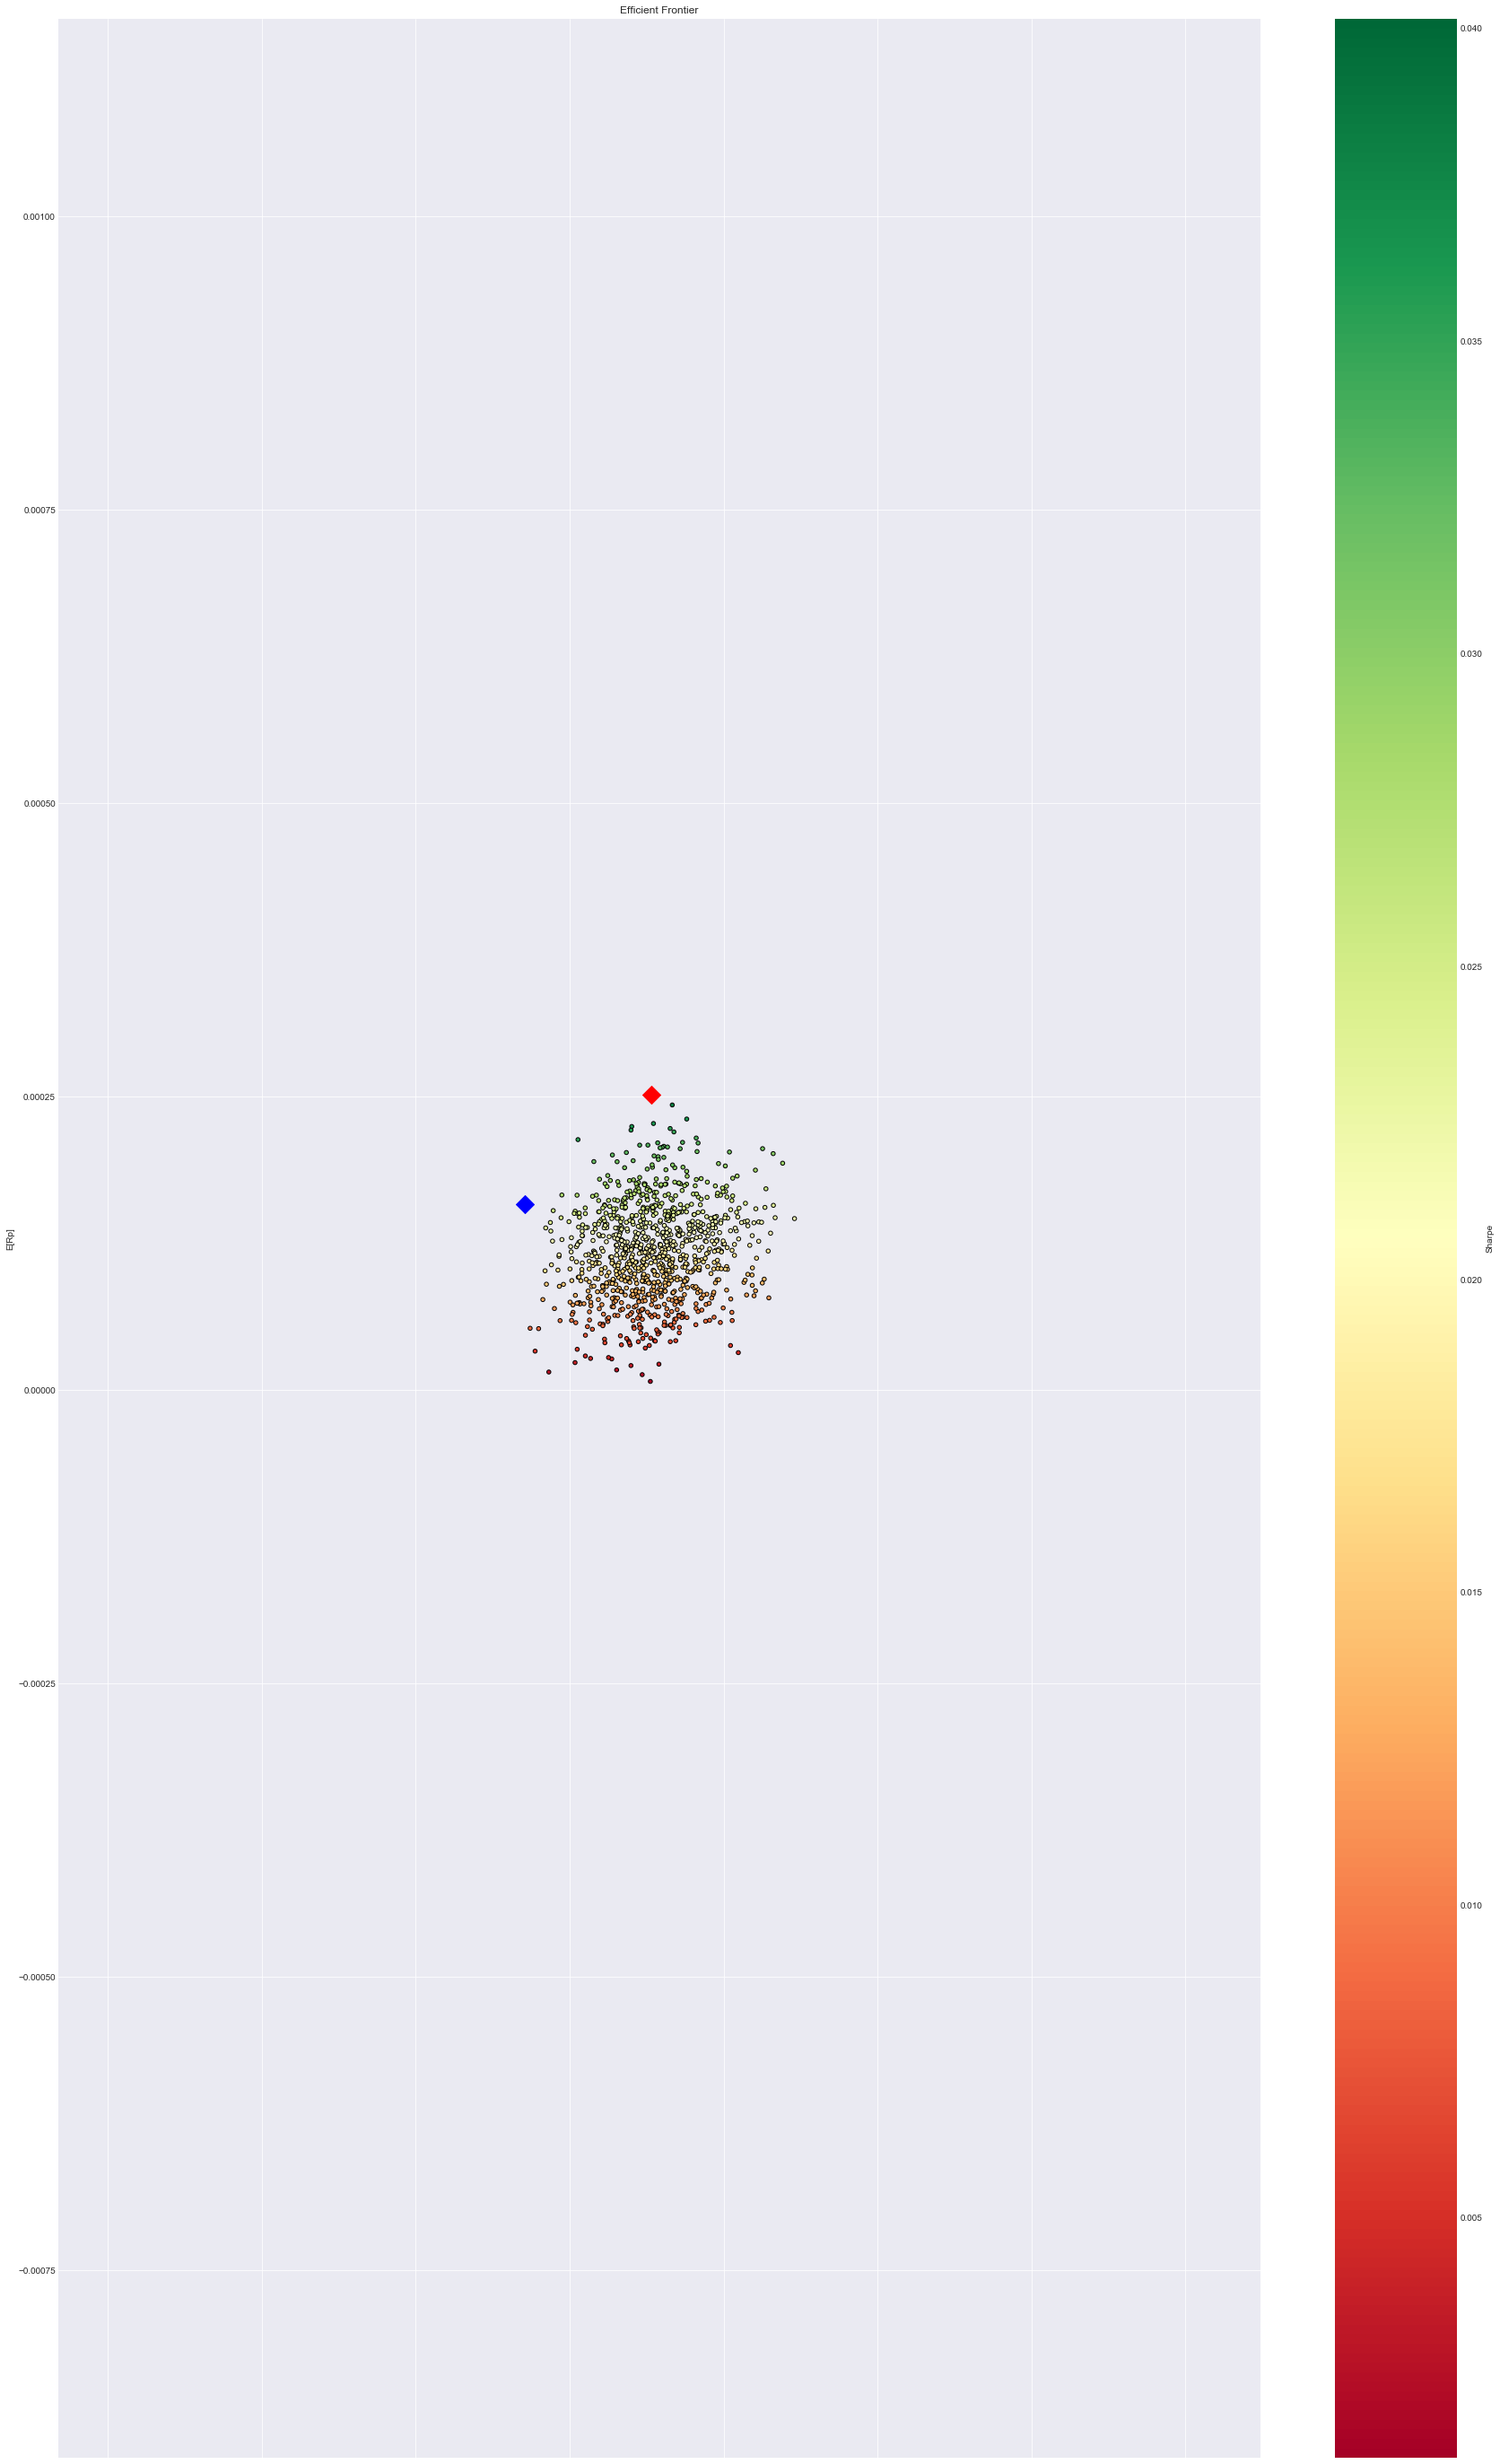

In [299]:
plt.style.use('seaborn-dark')
port.plot.scatter(x='Sigma', y='E[Rp]', c='Sharpe',
                cmap='RdYlGn', edgecolors='black' ,figsize=(30, 50), grid=True)
plt.scatter(x=sharpe_portfolio['Sigma'], y=sharpe_portfolio["E[Rp]"], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Sigma'], y=min_variance_port["E[Rp]"], c='blue', marker='D', s=200 )
plt.xlabel('Desv. Est.')
plt.ylabel('E[Rp]')
plt.title('Efficient Frontier')

In [289]:
menor = sharpe_portfolio
w = menor.iloc[:,2]
w

11    [0.015001724546649334, 0.0007615587331729181, ...
Name: W, dtype: object